# Label Transform

In [1]:
import sys
import os
from os import sep
from os.path import dirname, realpath
from pathlib import Path
from functools import partial, reduce
import logging

def get_cwd(fname, subdir, crunch_dir=realpath(Path.home()) +sep +'crunch' +sep):
    """
    Convenience function to make a directory string for the current file based on inputs.
    Jupyter Notebook in Anaconda invokes the Python interpreter in Anaconda's subdirectory
    which is why changing sys.argv[0] is necessary. In the future a better way to do this
    should be preferred..
    """
    return crunch_dir +subdir +fname

def fix_path(cwd):
    """
    Convenience function to fix argv and python path so that jupyter notebook can run the same as
    any script in crunch.
    """
    sys.argv[0] = cwd
    module_path = os.path.abspath(os.path.join('..'))
    if module_path not in sys.path:
        sys.path.append(module_path)

fname = 'dataload_test.ipynb'   # FILL
dir_name = 'model'              # FILL
fix_path(get_cwd(fname, dir_name +sep))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dask import delayed, compute
from torch.utils.data import TensorDataset, DataLoader
import torch

from ipywidgets import interact, interactive, fixed
from IPython.display import display

pd.set_option("display.max_rows", 100)
pd.set_option('display.max_columns', 50)

from common_util import RECON_DIR, JSON_SFX_LEN, DT_CAL_DAILY_FREQ, is_type, pd_common_idx_rows, remove_dups_list, set_loglevel, chained_filter, get_variants, dump_df, load_json, gb_transpose, pd_common_index_rows, filter_cols_below, inner_join, outer_join, ser_shift, list_get_dict, window_iter, benchmark
from common_util import pairwise, midx_get_level, midx_intersect, pd_common_idx_rows, midx_split, pd_midx_to_arr, window_iter, np_is_ndim
from model.common import DATASET_DIR, EXPECTED_NUM_HOURS, default_dataset
from model.data_util import datagen, align_first_last_cols, prune_nulls, prepare_transpose_data, prepare_label_data, prepare_target_data
from data.data_api import DataAPI
from data.access_util import df_getters as dg, col_subsetters2 as cs2
from recon.dataset_util import prep_dataset, gen_group
from recon.split_util import get_train_test_split, gen_time_series_split, index_three_split, pd_binary_clip

Using TensorFlow backend.


In [2]:
set_loglevel('info')

In [3]:
eod = 'mvp_labels_eod.json'
xeod = 'mvp_labels_xeod.json'

In [4]:
dataset_name = eod
assets_str = 'sp_500'
assets = list(map(str.strip, assets_str.split(',')))

In [34]:
dataset_dict = {
    'labels':  [['mvp_dir', 'direod'], ['mvp_dir', 'direod1_log']]
}
dataset = prep_dataset(dataset_dict, assets=assets)

# logging.info('dataset: {} {} df(s)'.format(len(dataset['features']['dfs']), dataset_name))
logging.info('assets: {}'.format(str('all' if (assets==None) else ', '.join(assets))))
# logging.debug('fpaths: {}'.format(str(list(dataset['features']['dfs'].keys()))))
logging.debug('lpaths: {}'.format(str(list(dataset['labels']['dfs'].keys()))))

lkey = list(dataset['labels']['dfs'].keys())[0]
l_df = dataset['labels']['dfs'][lkey].compute()

d_log = dataset['labels']['dfs'][list(dataset['labels']['dfs'].keys())[0]].compute()

for other in list(dataset['labels']['dfs'].keys())[1:]:
    d_log = inner_join(d_log, dataset['labels']['dfs'][other].compute(), r=str('_'+other[-1]))
print(d_log.columns)
d_log.rename(columns={d_log.columns[0]: list(dataset['labels']['dfs'].keys())[0][-1]}, inplace=True)
d_log.columns = ['0.000%', '0.0625%', '0.125%', '0.250%', '0.500%', '1.000%', '2.000%', '4.000%', '8.000%']
s_log = d_log.dropna().sum(axis=1)

INFO:root:assets: sp_500


Index(['pba_oc', 'pba_oc_raw_pba_oc_retxeod(0.062500%)_direod',
       'pba_oc_raw_pba_oc_retxeod(0.125000%)_direod',
       'pba_oc_raw_pba_oc_retxeod(0.250000%)_direod',
       'pba_oc_raw_pba_oc_retxeod(0.500000%)_direod',
       'pba_oc_raw_pba_oc_retxeod(1.000000%)_direod',
       'pba_oc_raw_pba_oc_retxeod(2.000000%)_direod',
       'pba_oc_raw_pba_oc_retxeod(4.000000%)_direod',
       'pba_oc_raw_pba_oc_retxeod(8.000000%)_direod'],
      dtype='object')


In [35]:
dataset_dict = {
    'labels':  [['mvp_dir', 'direod'], ['mvp_dir', 'direod1_lin']]
}
dataset = prep_dataset(dataset_dict, assets=assets)

# logging.info('dataset: {} {} df(s)'.format(len(dataset['features']['dfs']), dataset_name))
logging.info('assets: {}'.format(str('all' if (assets==None) else ', '.join(assets))))
# logging.debug('fpaths: {}'.format(str(list(dataset['features']['dfs'].keys()))))
logging.debug('lpaths: {}'.format(str(list(dataset['labels']['dfs'].keys()))))

lkey = list(dataset['labels']['dfs'].keys())[0]
l_df = dataset['labels']['dfs'][lkey].compute()

d_lin = dataset['labels']['dfs'][list(dataset['labels']['dfs'].keys())[0]].compute()

for other in list(dataset['labels']['dfs'].keys())[1:]:
    d_lin = inner_join(d_lin, dataset['labels']['dfs'][other].compute(), r=str('_'+other[-1]))
print(d_lin.columns)
d_lin.rename(columns={d_lin.columns[0]: list(dataset['labels']['dfs'].keys())[0][-1]}, inplace=True)
d_lin.columns = ['0.000%', '1.000%', '2.000%', '3.000%', '4.000%', '5.000%', '6.000%', '7.000%', '8.000%']
s_lin = d_lin.dropna().sum(axis=1)

INFO:root:assets: sp_500


Index(['pba_oc', 'pba_oc_raw_pba_oc_retxeod(1.000000%)_direod',
       'pba_oc_raw_pba_oc_retxeod(2.000000%)_direod',
       'pba_oc_raw_pba_oc_retxeod(3.000000%)_direod',
       'pba_oc_raw_pba_oc_retxeod(4.000000%)_direod',
       'pba_oc_raw_pba_oc_retxeod(5.000000%)_direod',
       'pba_oc_raw_pba_oc_retxeod(6.000000%)_direod',
       'pba_oc_raw_pba_oc_retxeod(7.000000%)_direod',
       'pba_oc_raw_pba_oc_retxeod(8.000000%)_direod'],
      dtype='object')


### Label Threshold Histograms

Labelling on a linear scale from 0% to 8% gives a familiar result

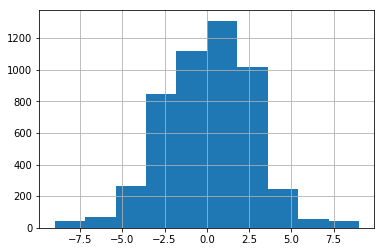

In [40]:
s_lin.hist(bins=len(d_lin.columns)+1)

Labelling on a exponential base-2 scale (where each increment is twice the previous) from 0%, .0625% to 8% gives something that appears more log normal.

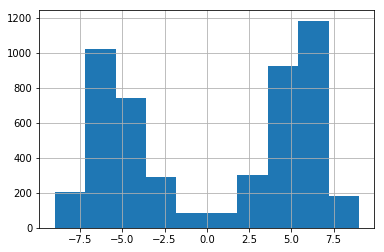

In [41]:
s_log.hist(bins=len(d_log.columns)+1)

In [35]:
def djoin(d, a, b):
    d1 = d['labels']['dfs'][a].compute()
    d2 = d['labels']['dfs'][b].compute()
    new = inner_join(d1, d2, l='_'+a[-1], r='_'+b[-1])
    return newa

In [36]:
reduce(partial(djoin, dataset), dataset['labels']['dfs'].keys()).compute()

ValueError: Unable to coerce to Series, length must be 2: given 3

In [29]:
list(dataset['labels']['dfs'].keys())

[['sp_500', 'direod', 'raw_pba_oc_retxeod_direod'],
 ['sp_500',
  'direod',
  'raw_pba_oc_retxeod_direod',
  'raw_pba_oc_retxeod(0.25%)_direod'],
 ['sp_500',
  'direod',
  'raw_pba_oc_retxeod_direod',
  'raw_pba_oc_retxeod(0.50%)_direod'],
 ['sp_500',
  'direod',
  'raw_pba_oc_retxeod_direod',
  'raw_pba_oc_retxeod(1.00%)_direod'],
 ['sp_500',
  'direod',
  'raw_pba_oc_retxeod_direod',
  'raw_pba_oc_retxeod(1.50%)_direod'],
 ['sp_500',
  'direod',
  'raw_pba_oc_retxeod_direod',
  'raw_pba_oc_retxeod(2.00%)_direod']]

In [25]:
l_df

pba_oc
id                               
1998-01-02 00:00:00+00:00     1.0
1998-01-03 00:00:00+00:00     NaN
1998-01-04 00:00:00+00:00     NaN
1998-01-05 00:00:00+00:00     1.0
1998-01-06 00:00:00+00:00    -1.0
1998-01-07 00:00:00+00:00    -1.0
1998-01-08 00:00:00+00:00    -1.0
1998-01-09 00:00:00+00:00    -1.0
1998-01-10 00:00:00+00:00     NaN
1998-01-11 00:00:00+00:00     NaN
1998-01-12 00:00:00+00:00     1.0
1998-01-13 00:00:00+00:00     1.0
1998-01-14 00:00:00+00:00     1.0
1998-01-15 00:00:00+00:00    -1.0
1998-01-16 00:00:00+00:00     1.0
1998-01-17 00:00:00+00:00     NaN
1998-01-18 00:00:00+00:00     NaN
1998-01-19 00:00:00+00:00     NaN
1998-01-20 00:00:00+00:00     1.0
1998-01-21 00:00:00+00:00    -1.0
1998-01-22 00:00:00+00:00    -1.0
1998-01-23 00:00:00+00:00    -1.0
1998-01-24 00:00:00+00:00     NaN
1998-01-25 00:00:00+00:00     NaN
1998-01-26 00:00:00+00:00    -1.0
1998-01-27 00:00:00+00:00     1.0
1998-01-28 00:00:00+00:00     1.0
1998-01-29 00:00:00+00:00     1.0
1998-01-30 00:00:00+00:00    -1.0
1998-01-31 00:00:00+00:00     NaN
1998-02-01 00:00:00+00:00     NaN
1998-02-02 00:00:00+00:00     1.0
1998-02-03 00:00:00+00:00     1.0
1998-02-04 00:00:00+00:00     1.0
1998-02-05 00:00:00+00:00    -1.0
1998-02-06 00:00:00+00:00     1.0
1998-02-07 00:00:00+00:00     NaN
1998-02-08 00:00:00+00:00     NaN
1998-02-09 00:00:00+00:00    -1.0
1998-02-10 00:00:00+00:00     1.0
1998-02-11 00:00:00+00:00     1.0
1998-02-12 00:00:00+00:00     1.0
1998-02-13 00:00:00+00:00    -1.0
1998-02-14 00:00:00+00:00     NaN
1998-02-15 00:00:00+00:00     NaN
1998-02-16 00:00:00+00:00     NaN
1998-02-17 00:00:00+00:00     1.0
1998-02-18 00:00:00+00:00     1.0
1998-02-19 00:00:00+00:00    -1.0
1998-02-20 00:00:00+00:00     1.0
...                           ...
2017-11-10 00:00:00+00:00     1.0
2017-11-11 00:00:00+00:00     NaN
2017-11-12 00:00:00+00:00     NaN
2017-11-13 00:00:00+00:00     1.0
2017-11-14 00:00:00+00:00     1.0
2017-11-15 00:00:00+00:00    -1.0
2017-11-16 00:00:00+00:00     1.0
2017-11-17 00:00:00+00:00    -1.0
2017-11-18 00:00:00+00:00     NaN
2017-11-19 00:00:00+00:00     NaN
2017-11-20 00:00:00+00:00     1.0
2017-11-21 00:00:00+00:00     1.0
2017-11-22 00:00:00+00:00    -1.0
2017-11-23 00:00:00+00:00     NaN
2017-11-24 00:00:00+00:00     1.0
2017-11-25 00:00:00+00:00     NaN
2017-11-26 00:00:00+00:00     NaN
2017-11-27 00:00:00+00:00    -1.0
2017-11-28 00:00:00+00:00     1.0
2017-11-29 00:00:00+00:00    -1.0
2017-11-30 00:00:00+00:00     1.0
2017-12-01 00:00:00+00:00    -1.0
2017-12-02 00:00:00+00:00     NaN
2017-12-03 00:00:00+00:00     NaN
2017-12-04 00:00:00+00:00    -1.0
2017-12-05 00:00:00+00:00    -1.0
2017-12-06 00:00:00+00:00     1.0
2017-12-07 00:00:00+00:00     1.0
2017-12-08 00:00:00+00:00     1.0
2017-12-09 00:00:00+00:00     NaN
2017-12-10 00:00:00+00:00     NaN
2017-12-11 00:00:00+00:00     1.0
2017-12-12 00:00:00+00:00     1.0
2017-12-13 00:00:00+00:00    -1.0
2017-12-14 00:00:00+00:00    -1.0
2017-12-15 00:00:00+00:00     1.0
2017-12-16 00:00:00+00:00     NaN
2017-12-17 00:00:00+00:00     NaN
2017-12-18 00:00:00+00:00     1.0
2017-12-19 00:00:00+00:00    -1.0
2017-12-20 00:00:00+00:00    -1.0
2017-12-21 00:00:00+00:00     1.0
2017-12-22 00:00:00+00:00    -1.0
2017-12-23 00:00:00+00:00     NaN
2017-12-24 00:00:00+00:00     NaN
2017-12-25 00:00:00+00:00     NaN
2017-12-26 00:00:00+00:00     1.0
2017-12-27 00:00:00+00:00     1.0
2017-12-28 00:00:00+00:00     1.0
2017-12-29 00:00:00+00:00    -1.0

[7302 rows x 1 columns]

In [22]:
for i, (fpath, lpath, tpath, frec, lrec, trec, fcol, lcol, tcol, feature, label, target) in enumerate(datagen(dataset, feat_prep_fn=prepare_transpose_data, label_prep_fn=prepare_label_data, target_prep_fn=prepare_target_data, how='df_to_ser')):
    logging.info('(X, y, z) -> ({fdesc}[{fcol}], {ldesc}[{lcol}], {tdesc}[{tcol}])'.format(fdesc=frec.desc, fcol=fcol, ldesc=lrec.desc, lcol=lcol, tdesc=trec.desc, tcol=tcol))
    f = feature
    pos_l, neg_l = pd_binary_clip(label)
    l = pos_l
    t = target
    break
#     print(feature)
#     print(label)
#     print(target)

INFO:root:(X, y, z) -> (raw[*], raw_pba_oc_retxeod_direod[pba_oc], raw_pba_oc_retxeod_reteod[pba_oc])


In [23]:
val_ratio = .2
test_ratio = .2
train_ratio = 1-(val_ratio+test_ratio)
f_train_idx, f_val_idx, f_test_idx = midx_split(f.index, train_ratio, val_ratio, test_ratio)
l_train_idx, l_val_idx, l_test_idx = midx_split(l.index, train_ratio, val_ratio, test_ratio)
t_train_idx, t_val_idx, t_test_idx = midx_split(t.index, train_ratio, val_ratio, test_ratio)

In [24]:
feat_train, feat_val, feat_test = f.loc[f_train_idx], f.loc[f_val_idx], f.loc[f_test_idx]
lab_train, lab_val, lab_test = l.loc[l_train_idx], l.loc[l_val_idx], l.loc[l_test_idx]
tar_train, tar_val, tar_test = t.loc[t_train_idx], t.loc[t_val_idx], t.loc[t_test_idx]

In [25]:
feat_train_np, feat_val_np, feat_val_np = map(pd_midx_to_arr, [feat_train.stack(), feat_val.stack(), feat_test.stack()])
lab_train_np, lab_val_np, lab_test_np = lab_train.values, lab_val.values, lab_test.values
tar_train_np, tar_val_np, tar_test_np = tar_train.values, tar_val.values, tar_test.values

In [27]:
t_params = {
    'input_windows': 10
}

In [28]:
def t_preproc(params, data):
    # Reshape features into overlapping moving window samples
    f = np.array([np.concatenate(vec, axis=-1) for vec in window_iter(data[0], n=params['input_windows'])])

    if (len(f.shape) < 3):
        f = np.expand_dims(f, 1) # Add a singleton dimension for single channel data

    l = []
    for vec in data[1:]:
        r = vec[params['input_windows']-1:]								# Realign by dropping lables prior to the first step
        m = np.expand_dims(r, 1) if (np_is_ndim(vec)) else r 			# Make array vector of vectors if it is one dimensional
        l.append(m)

    return (f, *l)

In [29]:
to_ds = lambda *data: TensorDataset(*[torch.tensor(d) for d in data])
data_tuples = zip([feat_train_np, feat_val_np, feat_test_np], [lab_train_np, lab_val_np, lab_test_np])
train_ds, val_ds, test_ds = [to_ds(*t_preproc(t_params, (X, y))) for X, y in data_tuples]
train_dl, val_dl, test_dl = map(partial(DataLoader, batch_size=10, shuffle=False), [train_ds, val_ds, test_ds])

In [30]:
for xb, yb in train_dl:
    print('xb:', xb)
    print('yb:', yb)

xb: tensor([[[436.9066, 434.6690, 434.5008,  ..., 421.6779, 421.7339, 421.7527],
         [435.9600, 434.4300, 434.5100,  ..., 421.7100, 421.8000, 421.7500],
         [437.5600, 435.9800, 434.6400,  ..., 421.8500, 422.0200, 421.8400],
         [435.9600, 434.2500, 434.3500,  ..., 421.4200, 421.3800, 421.7500],
         [437.0200, 435.9800, 434.4200,  ..., 421.7900, 421.7000, 421.8100]],

        [[436.8630, 437.2328, 437.6746,  ..., 426.1602, 426.1464, 426.2436],
         [436.6800, 437.4300, 438.1100,  ..., 426.0700, 426.0300, 426.2500],
         [437.1400, 437.5500, 438.1200,  ..., 426.4100, 426.3400, 426.2500],
         [436.5200, 436.6600, 437.4300,  ..., 426.0000, 425.9100, 426.0400],
         [436.5200, 436.6700, 437.4800,  ..., 426.4000, 426.0600, 426.0400]],

        [[435.1514, 434.6411, 434.0325,  ..., 429.6798, 430.5885, 431.3052],
         [434.6800, 434.5700, 433.4000,  ..., 430.3200, 431.0500, 431.3100],
         [437.0600, 434.8500, 434.5600,  ..., 430.3500, 431.0600, 43

xb: tensor([[[523.0882, 523.3315, 521.4459,  ..., 502.7414, 502.6667, 503.6254],
         [522.4700, 522.5500, 521.1700,  ..., 503.1200, 503.4400, 503.6300],
         [524.1100, 523.6800, 522.5400,  ..., 503.2900, 503.4400, 503.6300],
         [522.0400, 522.4800, 521.1500,  ..., 501.8700, 502.1700, 503.4600],
         [522.7000, 522.4800, 522.5400,  ..., 501.9000, 503.1000, 503.4600]],

        [[516.3227, 512.9845, 512.5257,  ..., 508.7231, 509.1434, 509.8801],
         [515.8900, 512.8400, 512.0900,  ..., 508.1900, 510.1600, 509.8700],
         [517.4100, 515.9500, 512.9300,  ..., 509.7400, 510.1600, 510.2500],
         [514.2500, 511.5900, 512.0300,  ..., 508.0100, 508.2000, 509.8700],
         [514.2500, 515.9200, 512.8200,  ..., 508.5600, 508.2200, 510.2500]],

        [[510.6746, 506.8067, 504.5191,  ..., 509.5755, 509.9249, 508.7321],
         [509.3400, 505.0300, 505.6100,  ..., 509.6700, 508.9700, 508.7200],
         [514.3300, 509.4700, 505.6100,  ..., 509.8400, 510.4800, 50

xb: tensor([[[395.0426, 395.2216, 397.1007,  ..., 418.7920, 418.8679, 419.2286],
         [395.7800, 396.1600, 397.0000,  ..., 418.8900, 419.1500, 419.2300],
         [395.8000, 396.1600, 397.8300,  ..., 419.1900, 419.1500, 419.2300],
         [394.4600, 394.6900, 396.2100,  ..., 418.5100, 418.6000, 419.1900],
         [395.7800, 395.8200, 396.2100,  ..., 419.1900, 418.8900, 419.2000]],

        [[397.6488, 395.0492, 396.1005,  ..., 419.4935, 419.7093, 419.4387],
         [397.0400, 395.5800, 396.5300,  ..., 419.3100, 419.3800, 419.4400],
         [398.6800, 397.0300, 396.5300,  ..., 419.9900, 420.1500, 419.4400],
         [397.0400, 394.1900, 395.5900,  ..., 419.0500, 419.3100, 419.4000],
         [398.6800, 397.0300, 395.5900,  ..., 419.9800, 419.3100, 419.4000]],

        [[401.3414, 403.9472, 404.8992,  ..., 420.9526, 421.5111, 422.0468],
         [403.3900, 404.1300, 405.2300,  ..., 421.4900, 421.9400, 422.0500],
         [403.3900, 404.9400, 405.3400,  ..., 421.4900, 422.0100, 42

xb: tensor([[[685.7832, 684.6461, 685.8276,  ..., 673.9996, 674.1823, 673.2126],
         [685.2800, 685.1300, 685.0500,  ..., 674.2400, 672.9800, 673.2200],
         [687.1200, 685.3500, 686.6300,  ..., 674.8300, 675.1600, 673.2200],
         [684.7400, 684.0400, 685.0500,  ..., 673.3700, 672.9800, 673.0600],
         [684.7400, 685.2700, 685.1100,  ..., 673.6800, 674.2300, 673.0600]],

        [[679.8897, 679.3599, 678.7706,  ..., 677.9190, 683.9701, 684.0539],
         [678.7000, 678.4700, 678.6100,  ..., 680.5200, 683.9300, 684.0500],
         [683.2400, 680.1700, 679.1700,  ..., 681.0800, 685.2300, 684.1400],
         [678.7000, 678.2800, 678.4900,  ..., 672.6100, 680.5100, 684.0500],
         [683.0900, 678.7300, 678.4900,  ..., 672.6600, 680.5100, 684.1400]],

        [[672.2120, 670.1875, 672.5456,  ..., 688.2570, 689.2038, 689.2574],
         [671.8000, 671.3200, 672.9500,  ..., 688.2200, 689.6800, 689.2500],
         [672.6100, 671.7100, 673.5100,  ..., 689.5100, 690.1600, 68

xb: tensor([[[735.5674, 732.6821, 731.8085,  ..., 736.9414, 734.4151, 738.5085],
         [733.8600, 732.4400, 730.0400,  ..., 732.8100, 738.2900, 738.5100],
         [739.0400, 734.3500, 732.8100,  ..., 739.4900, 738.2900, 738.5100],
         [732.6400, 731.3800, 730.0400,  ..., 732.5200, 731.5700, 738.4300],
         [738.8800, 734.0200, 732.4900,  ..., 738.7000, 732.7700, 738.4300]],

        [[730.7744, 731.7280, 734.0114,  ..., 740.0225, 739.7858, 741.9228],
         [729.4500, 738.5700, 732.4200,  ..., 739.0600, 742.2500, 741.9100],
         [734.2600, 738.5700, 738.4600,  ..., 742.5900, 742.7600, 742.1600],
         [727.9100, 726.4200, 731.0700,  ..., 738.5500, 737.4600, 741.9100],
         [730.7500, 729.3700, 738.4600,  ..., 742.2100, 739.0700, 742.1600]],

        [[726.9541, 726.1114, 723.6308,  ..., 718.5587, 720.9380, 718.6405],
         [728.9300, 724.3100, 724.8300,  ..., 719.6900, 719.1100, 718.6200],
         [728.9900, 729.8500, 725.2300,  ..., 720.7800, 722.3500, 71